# GenreMatch
Data cleaning and model generation  
*Jeremy Freedman, Reza Madhavan, Kunal Sheth*

In [2]:
!unzip Archive.zip

unzip:  cannot find or open Archive.zip, Archive.zip.zip or Archive.zip.ZIP.


In [3]:
!ls utils

azlyrics.py  grab_genius.ipynb	__pycache__
genius.py    grab_lyrics.py	songlyrics.py


In [4]:
import pandas as pd
import numpy as np
import utils.songlyrics as sl
from collections import defaultdict
from nltk.corpus import stopwords as sw
from nltk import download as nltk_download
import matplotlib.pyplot as pyplot
import sklearn as sk
from sklearn import tree
import collections
import gc
import math
import pickle
import json

In [5]:
a=pd.read_csv('data/song_lyrics.csv').dropna()
new_df = a.copy()
head = new_df.head(5)

In [6]:
# download the NLTK stopwords list, if necessary
nltk_download('stopwords')

[nltk_data] Downloading package stopwords to /home/jerem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# we need to clean and update the NLTK stopwords for our data
# we're stripping out punctuation entirely, which the stopwords are not equipped to handle
# could optionally add music-centric stopwords ('oh', 'yeah', 'like', etc)

temp_words = sw.words('english')
stopwords = []
additions = ['im', 'ill', 'id', 'oh', 'cant', 'ive']
for w in temp_words:
    stopwords.append(sl._clean(w))
stopwords += additions
print(stopwords)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', '

In [8]:
for index,row in new_df.iterrows():
  if index % 100 == 0:
    print(index)

  song = row['Lyrics']
  x=song.find('\n')
  song2 = sl._clean(song[x+1:])
  new_song = ''
  for i in range(len(song2)):
    char = song2[i]

    if char == '\n':
      new_song += ' '
    elif char == '(' or char == ')':
      new_song += ''
    else:
      new_song += char


    new_song = new_song.encode('ascii','ignore').decode()

  song2 = new_song.split(' ')
  song2 = list(filter(lambda x : x!='' and x not in stopwords, song2))
  song2 = song2[:len(song2)-1]

  new_df.at[index, 'Lyrics'] = song2


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000


In [39]:
wordfreq = []
word_appearance_cnt = defaultdict(int) # how many songs contain word W? used for IDF
for index,row in new_df.iterrows():
  lyrics = row['Lyrics']
  x = dict(collections.Counter(lyrics))
  for w in x:
    word_appearance_cnt[w] += 1
  # mapped = []
  # for k in x.keys():
  #   mapped.append((k,x[k]))
  wordfreq.append(x)
# specify how many words (most popular first) to turn into features:
top_words = {k : v for k, v in sorted(word_appearance_cnt.items(), key=lambda x: x[1], reverse=True)[:1200]}
new_df['WordFreq'] = wordfreq

In [40]:
new_df['UniqueWords']= new_df.apply(lambda row : len(row['WordFreq']), axis = 1)
new_df

,Unnamed: 0,Artist,Song,Lyrics,Genre,WordFreq,UniqueWords
0,0,One Direction,Perfect,"[might, never, knight, shinin, armor, might, n...",pop,"{'might': 4, 'never': 4, 'knight': 1, 'shinin'...",71
1,1,One Direction,Story of My Life,"[written, walls, stories, explain, leave, hear...",pop,"{'written': 3, 'walls': 2, 'stories': 1, 'expl...",68
2,2,One Direction,Drag Me Down,"[got, fire, heart, scared, dark, never, seen, ...",pop,"{'got': 4, 'fire': 2, 'heart': 2, 'scared': 2,...",37
3,3,One Direction,What Makes You Beautiful,"[insecure, know, turning, heads, walk, door, n...",pop,"{'insecure': 1, 'know': 18, 'turning': 1, 'hea...",54
4,4,One Direction,Night Changes,"[going, tonight, changes, something, red, moth...",pop,"{'going': 2, 'tonight': 3, 'changes': 8, 'some...",65
...,...,...,...,...,...,...,...
4074,4074,Def Leppard,Action! Not Words,"[sick, tired, damn, tv, gonna, make, movie, wa...",metal,"{'sick': 1, 'tired': 1, 'damn': 1, 'tv': 1, 'g...",61
4075,4075,Def Leppard,Rock Rock (Till You Drop),"[ready, get, set, tear, place, apart, need, ti...",metal,"{'ready': 1, 'get': 2, 'set': 1, 'tear': 1, 'p...",74
4076,4076,Def Leppard,Slang,"[sitting, dark, getting, taken, said, somethin...",metal,"{'sitting': 1, 'dark': 1, 'getting': 1, 'taken...",41
4077,4077,Def Leppard,Die Hard the Hunter,"[lets, welcome, home, soldier, boy, far, away,...",metal,"{'lets': 2, 'welcome': 2, 'home': 2, 'soldier'...",65


In [41]:
# uniq_words = set()
# for x in new_df['WordFreq']:
#   uniq_words = uniq_words.union(x.keys())
uniq_wordict = {k : 0 for k in top_words.keys()}

In [42]:
word_df = new_df[['Genre', 'WordFreq', 'Artist', 'UniqueWords']]

for index,row in word_df.iterrows():
  if index % 100 == 0:
    print(f'\r{100 * index // len(new_df)}%', end='')
  for k in row['WordFreq']:
    if k in top_words.keys():
      # uniq_wordict[k] = row['WordFreq'][k] # original (raw count)
      uniq_wordict[k] = row['WordFreq'][k] * math.log(len(new_df) / word_appearance_cnt[k]) # tf-idf

  word_df.at[index, 'WordFreq'] = uniq_wordict
  word_df.at[index, 'Artist'] = list(uniq_wordict.values()) + [row['UniqueWords']]
  uniq_wordict = {k : 0 for k in top_words.keys()}
print(f'\rDone', end='')
word_df = word_df.replace({'Artist':'WordFreqList'})


Done

In [43]:
# free up memory
gc.collect()

0

In [44]:
word_df = word_df.rename(columns = {'Artist':'WordFreqList'})
print(word_df)

      Genre                                           WordFreq  \
0       pop  {'know': 1.6510219263476484, 'like': 10.864738...   
1       pop  {'know': 0.5503406421158828, 'like': 0.5718283...   
2       pop  {'know': 0, 'like': 0, 'got': 3.10372765819156...   
3       pop  {'know': 9.90613155808589, 'like': 2.287313447...   
4       pop  {'know': 0.5503406421158828, 'like': 1.1436567...   
...     ...                                                ...   
4074  metal  {'know': 0, 'like': 0, 'got': 0.77593191454789...   
4075  metal  {'know': 0, 'like': 0, 'got': 1.55186382909578...   
4076  metal  {'know': 0, 'like': 0, 'got': 0, 'yeah': 2.376...   
4077  metal  {'know': 0.5503406421158828, 'like': 0, 'got':...   
4078  metal  {'know': 0, 'like': 0, 'got': 7.75931914547891...   

                                           WordFreqList  UniqueWords  
0     [1.6510219263476484, 10.864738875198876, 0, 2....           71  
1     [0.5503406421158828, 0.5718283618525725, 0, 0,...          

In [47]:
# write wordlist to disk for frontend use
print(f'total of {len(top_words.keys())} uniq words')
with open('data/words.txt', 'w') as f:
    top_words["SONG_CNT"] = len(new_df)
    f.write(str(top_words))


total of 1201 uniq words


In [48]:
print(len(word_df.head(1)['WordFreqList'][0]))

1201


In [49]:
# trying various splits
x_split_plt = []
y_split_plt = []
for i in range(10, 91, 10):
    X_train, X_test, Y_train, Y_test = \
        sk.model_selection.train_test_split(list(word_df['WordFreqList']), list(word_df['Genre']), test_size=0.01*i)
    print(f'Split ratio: {len(X_test) / (len(X_test) + len(X_train))}')
    x_split_plt.append(i)
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train,Y_train)
    preds = clf.predict(X_test)
    y_split_plt.append(np.sum(preds == Y_test)/len(preds))


Split ratio: 0.10004904364884748
Split ratio: 0.20009808729769496
Split ratio: 0.30014713094654244
Split ratio: 0.4001961745953899
Split ratio: 0.5
Split ratio: 0.6000490436488475
Split ratio: 0.700098087297695
Split ratio: 0.8001471309465424
Split ratio: 0.9001961745953899


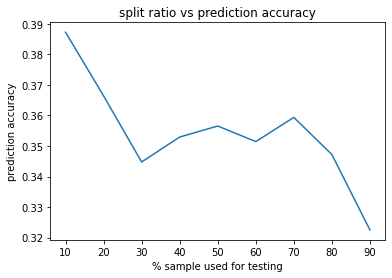

Best split: 0.1


In [50]:
# plotting split
pyplot.plot(x_split_plt, y_split_plt)
pyplot.title('split ratio vs prediction accuracy')
pyplot.xlabel('% sample used for testing')
pyplot.ylabel('prediction accuracy')
pyplot.show()
best_split = x_split_plt[y_split_plt.index(max(y_split_plt))] * 0.01
print(f'Best split: {best_split}')
X_train, X_test, Y_train, Y_test = \
        sk.model_selection.train_test_split(list(word_df['WordFreqList']), list(word_df['Genre']), test_size=best_split)

In [51]:
# trying various max depths
x_depth_plt = []
y_depth_plt = []
for i in range(1,102, 5):
    print(f'max depth {i}')
    x_depth_plt.append(i)
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train,Y_train)
    preds = clf.predict(X_test)
    y_depth_plt.append(np.sum(preds == Y_test)/len(preds))
    print(f'actual depth: {clf.get_depth()}')


max depth 1
actual depth: 1
max depth 6
actual depth: 6
max depth 11
actual depth: 11
max depth 16
actual depth: 16
max depth 21
actual depth: 21
max depth 26
actual depth: 26
max depth 31
actual depth: 31
max depth 36
actual depth: 36
max depth 41
actual depth: 41
max depth 46
actual depth: 40
max depth 51
actual depth: 41
max depth 56
actual depth: 40
max depth 61
actual depth: 41
max depth 66
actual depth: 39
max depth 71
actual depth: 39
max depth 76
actual depth: 41
max depth 81
actual depth: 39
max depth 86
actual depth: 39
max depth 91
actual depth: 39
max depth 96
actual depth: 39
max depth 101
actual depth: 40


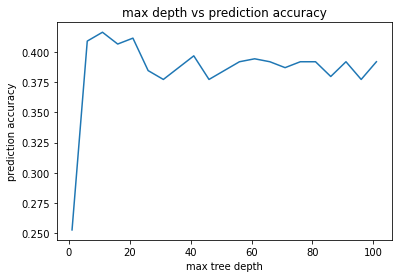

Best max depth: 11


In [52]:
# plotting depth
pyplot.plot(x_depth_plt, y_depth_plt)
pyplot.title('max depth vs prediction accuracy')
pyplot.xlabel('max tree depth')
pyplot.ylabel('prediction accuracy')
pyplot.show()
best_depth = x_depth_plt[y_depth_plt.index(max(y_depth_plt))] 
print(f'Best max depth: {best_depth}')

In [53]:
# trying various min leaf sample sizes
x_sample_plt = []
y_sample_plt = []
print(best_split)
for i in range(1, 101, 10):
    print(f'min leaf sample {i}')
    x_sample_plt.append(i)
    clf = tree.DecisionTreeClassifier(min_samples_leaf=i, max_depth=best_depth)
    clf.fit(X_train,Y_train)
    preds = clf.predict(X_test)
    y_sample_plt.append(np.sum(preds == Y_test)/len(preds))

0.1
min leaf sample 1
min leaf sample 11
min leaf sample 21
min leaf sample 31
min leaf sample 41
min leaf sample 51
min leaf sample 61
min leaf sample 71
min leaf sample 81
min leaf sample 91


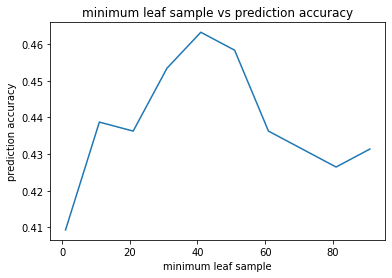

Best min leaf sample: 41


In [54]:
# plotting min leaf sample
pyplot.plot(x_sample_plt, y_sample_plt)
pyplot.title('minimum leaf sample vs prediction accuracy')
pyplot.xlabel('minimum leaf sample')
pyplot.ylabel('prediction accuracy')
pyplot.show()
best_leaf_sample = x_sample_plt[y_sample_plt.index(max(y_sample_plt))]
print(f'Best min leaf sample: {best_leaf_sample}')

In [55]:
# commit model to disk
clf_final = tree.DecisionTreeClassifier(min_samples_leaf=best_leaf_sample, max_depth=best_depth)
clf_final.fit(X_train,Y_train)
with open('model_dtc.pkl', 'wb') as f:
    pickle.dump(clf_final, f)

In [56]:
# assess final accuracy
preds = clf_final.predict(X_test)
print(np.sum(preds == Y_test)/len(preds))

0.4632352941176471





---
# STOP